<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/02.%20Deep%20Learning/01.%20Week%201/Notebooks/01.from_linear_to_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Linear Regression to Neural Networks

**Perjalanan memahami Neural Network dari fondasi paling dasar**

Notebook ini akan membawa kalian memahami bagaimana Neural Network sebenarnya adalah evolusi natural dari model-model sederhana yang mungkin sudah kalian kenal:

1. **Linear Regression** → Memprediksi nilai kontinu
2. **Logistic Regression** → Memprediksi probabilitas/klasifikasi
3. **"What if we stack them?"** → Neural Network!

---

## Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cpu


---
# Part 1: Linear Regression

## Konsep Dasar

Linear Regression adalah model paling sederhana dalam machine learning. Idenya:

$$\hat{y} = w \cdot x + b$$

Di mana:
- $x$ = input (features)
- $w$ = weight (slope)
- $b$ = bias (intercept)
- $\hat{y}$ = predicted output

**Goal:** Mencari nilai $w$ dan $b$ yang meminimalkan error antara prediksi dan nilai sebenarnya.

## 1.1 Generate Data untuk Regression

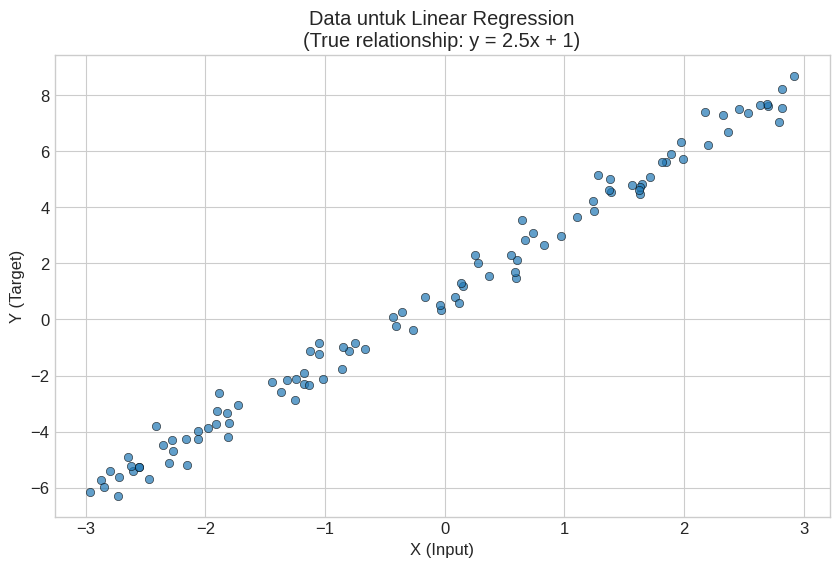

X shape: (100, 1)
y shape: (100, 1)


In [ ]:
# Generate simple linear data dengan sedikit noise
n_samples = 100
X_reg = np.random.uniform(-3, 3, (n_samples, 1))
y_reg = 2.5 * X_reg + 1.0 + np.random.normal(0, 0.5, (n_samples, 1))  # y = 2.5x + 1 + noise

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_reg, y_reg, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.xlabel('X (Input)')
plt.ylabel('Y (Target)')
plt.title('Data untuk Linear Regression\n(True relationship: y = 2.5x + 1)')
plt.show()

print(f"X shape: {X_reg.shape}")
print(f"y shape: {y_reg.shape}")

## 1.2 Linear Regression dengan PyTorch (Manual Way)

Pertama, kita akan implement secara manual untuk memahami mekanismenya:

In [ ]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_reg)
y_tensor = torch.FloatTensor(y_reg)

# Initialize parameters dengan requires_grad=True untuk tracking gradients
w = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

print(f"Initial weight: {w.item():.4f}")
print(f"Initial bias: {b.item():.4f}")

Initial weight: 0.3367
Initial bias: 0.0000


In [ ]:
# Training loop manual
learning_rate = 0.1
n_epochs = 100
losses = []

for epoch in range(n_epochs):
    # Forward pass: y_pred = w * x + b
    y_pred = X_tensor * w + b

    # Compute loss (Mean Squared Error)
    loss = ((y_pred - y_tensor) ** 2).mean()
    losses.append(loss.item())

    # Backward pass: compute gradients
    loss.backward()

    # Update parameters (gradient descent)
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Zero gradients for next iteration
    w.grad.zero_()
    b.grad.zero_()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, w: {w.item():.4f}, b: {b.item():.4f}")

print(f"\nFinal: w = {w.item():.4f} (true: 2.5), b = {b.item():.4f} (true: 1.0)")

Epoch [20/100], Loss: 0.2016, w: 2.4617, b: 0.9926
Epoch [40/100], Loss: 0.2016, w: 2.4617, b: 0.9926
Epoch [60/100], Loss: 0.2016, w: 2.4617, b: 0.9926
Epoch [80/100], Loss: 0.2016, w: 2.4617, b: 0.9926
Epoch [100/100], Loss: 0.2016, w: 2.4617, b: 0.9926

Final: w = 2.4617 (true: 2.5), b = 0.9926 (true: 1.0)


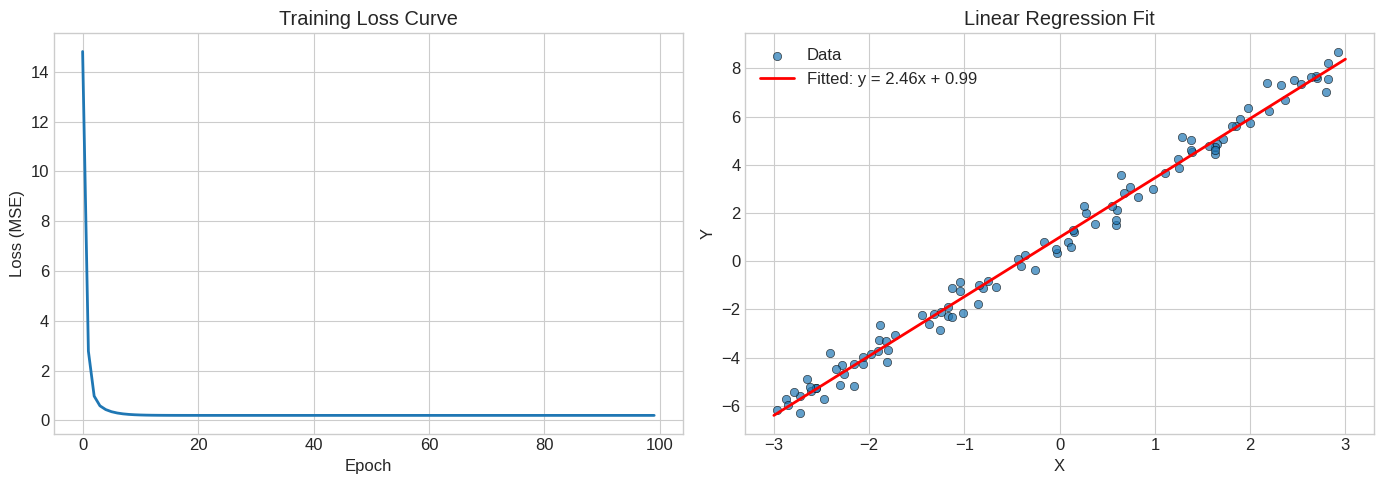

In [ ]:
# Visualize hasil training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curve
axes[0].plot(losses, linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training Loss Curve')

# Plot 2: Fitted line
axes[1].scatter(X_reg, y_reg, alpha=0.7, edgecolors='black', linewidth=0.5, label='Data')
x_line = np.linspace(-3, 3, 100)
y_line = w.item() * x_line + b.item()
axes[1].plot(x_line, y_line, 'r-', linewidth=2, label=f'Fitted: y = {w.item():.2f}x + {b.item():.2f}')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('Linear Regression Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

## 1.3 Linear Regression dengan nn.Module (PyTorch Way)

Sekarang kita gunakan cara yang lebih "PyTorch-ic" dengan `nn.Module`:

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Instantiate model
model_lr = LinearRegression(input_dim=1, output_dim=1)

# Loss function dan optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model_lr.parameters(), lr=0.1)

print("Model architecture:")
print(model_lr)
print(f"\nParameters: {list(model_lr.parameters())}")

Model architecture:
LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameters: [Parameter containing:
tensor([[-0.2191]], requires_grad=True), Parameter containing:
tensor([0.2018], requires_grad=True)]


In [ ]:
# Training
n_epochs = 100
losses_v2 = []

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_lr(X_tensor)
    loss = criterion(y_pred, y_tensor)
    losses_v2.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract learned parameters
w_learned = model_lr.linear.weight.item()
b_learned = model_lr.linear.bias.item()
print(f"✅ Learned: w = {w_learned:.4f}, b = {b_learned:.4f}")

✅ Learned: w = 2.4617, b = 0.9926


## 💡 Key Insight: Linear Regression

Linear Regression pada dasarnya adalah:
- **1 layer** dengan **linear transformation**
- Output langsung dari weighted sum: $y = Wx + b$
- Cocok untuk relationship yang **linear**

**Pertanyaan:** Bagaimana kalau kita mau klasifikasi? 🤔

---
# Part 2: Logistic Regression

## Konsep Dasar

Logistic Regression = Linear Regression + **Sigmoid Activation**

$$\hat{y} = \sigma(w \cdot x + b) = \frac{1}{1 + e^{-(wx + b)}}$$

Sigmoid function "squashes" output ke range [0, 1] → bisa diinterpretasikan sebagai **probabilitas**!

## 2.1 Visualisasi Sigmoid Function

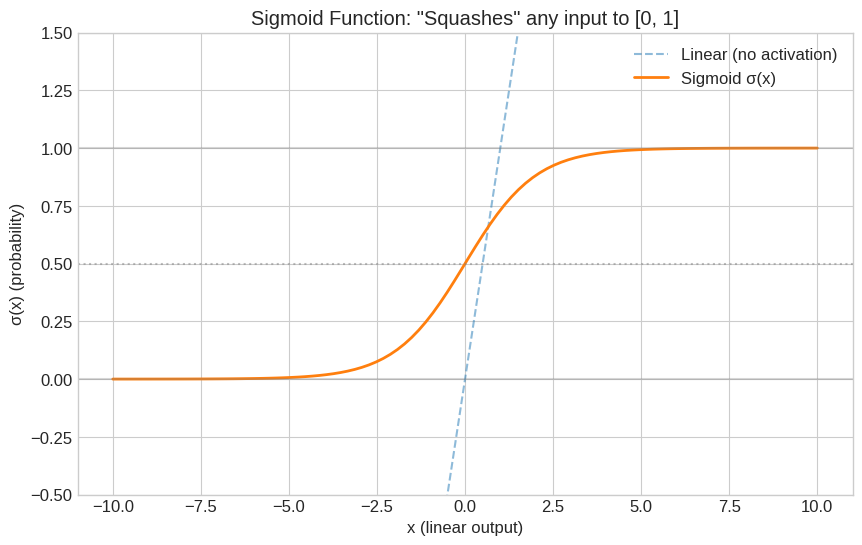

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10, 10, 100)

plt.figure(figsize=(10, 6))
plt.plot(x, x, '--', label='Linear (no activation)', alpha=0.5)
plt.plot(x, sigmoid(x), linewidth=2, label='Sigmoid σ(x)')
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('x (linear output)')
plt.ylabel('σ(x) (probability)')
plt.title('Sigmoid Function: "Squashes" any input to [0, 1]')
plt.legend()
plt.ylim(-0.5, 1.5)
plt.show()

## 2.2 Generate Data untuk Classification

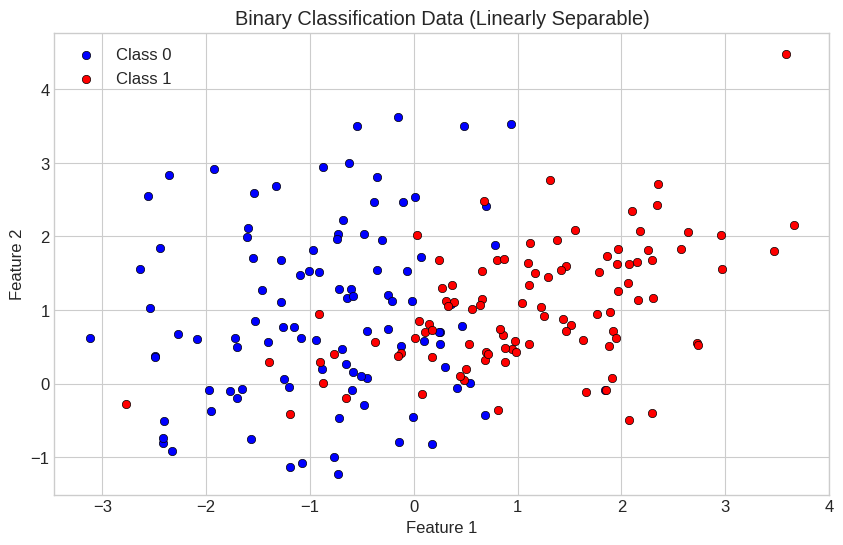

In [ ]:
# Linearly separable data
X_class, y_class = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_class[y_class==0, 0], X_class[y_class==0, 1],
            c='blue', label='Class 0', edgecolors='black', linewidth=0.5)
plt.scatter(X_class[y_class==1, 0], X_class[y_class==1, 1],
            c='red', label='Class 1', edgecolors='black', linewidth=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Data (Linearly Separable)')
plt.legend()
plt.show()

## 2.3 Logistic Regression Model

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)     # Linear: wx + b
        out = self.sigmoid(out)  # Squash to [0, 1]
        return out

# Prepare data
X_tensor_class = torch.FloatTensor(X_class)
y_tensor_class = torch.FloatTensor(y_class).reshape(-1, 1)

# Model
model_logistic = LogisticRegression(input_dim=2)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.SGD(model_logistic.parameters(), lr=0.5)

print("Logistic Regression = Linear + Sigmoid")
print(model_logistic)

Logistic Regression = Linear + Sigmoid
LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Training
n_epochs = 200
losses_logistic = []
accuracies = []

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_logistic(X_tensor_class)
    loss = criterion(y_pred, y_tensor_class)
    losses_logistic.append(loss.item())

    # Compute accuracy
    predicted = (y_pred > 0.5).float()
    accuracy = (predicted == y_tensor_class).float().mean()
    accuracies.append(accuracy.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

print(f"\nFinal Accuracy: {accuracies[-1]*100:.2f}%")

Epoch [50/200], Loss: 0.3659, Accuracy: 0.8400
Epoch [100/200], Loss: 0.3659, Accuracy: 0.8400
Epoch [150/200], Loss: 0.3659, Accuracy: 0.8400
Epoch [200/200], Loss: 0.3659, Accuracy: 0.8400

Final Accuracy: 84.00%


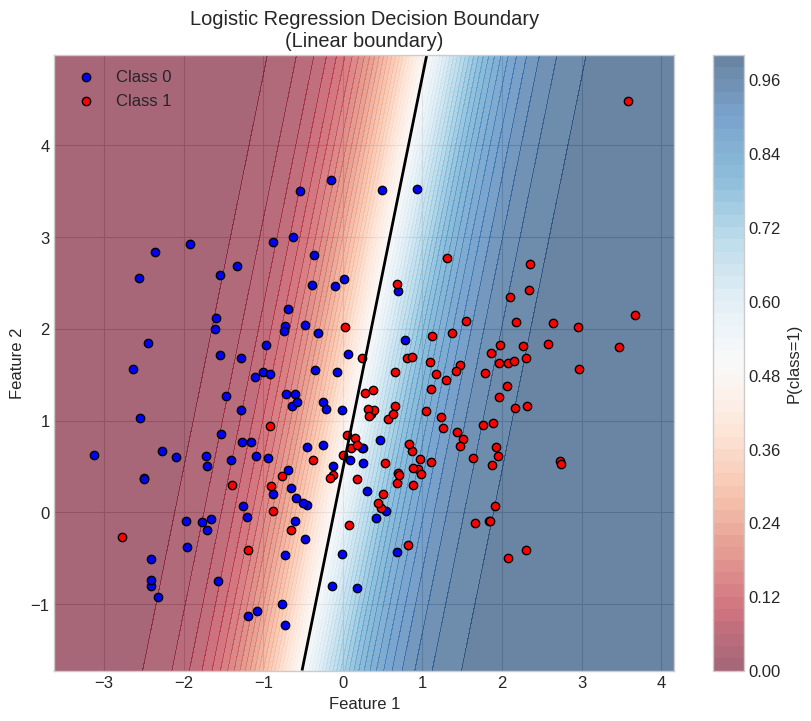

In [ ]:
# Visualize decision boundary
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(grid).numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label='P(class=1)')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', edgecolors='black')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', edgecolors='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()

plt.figure(figsize=(10, 8))
plot_decision_boundary(model_logistic, X_class, y_class,
                       'Logistic Regression Decision Boundary\n(Linear boundary)')
plt.show()

## 2.4 Problem: Data yang TIDAK Linear Separable

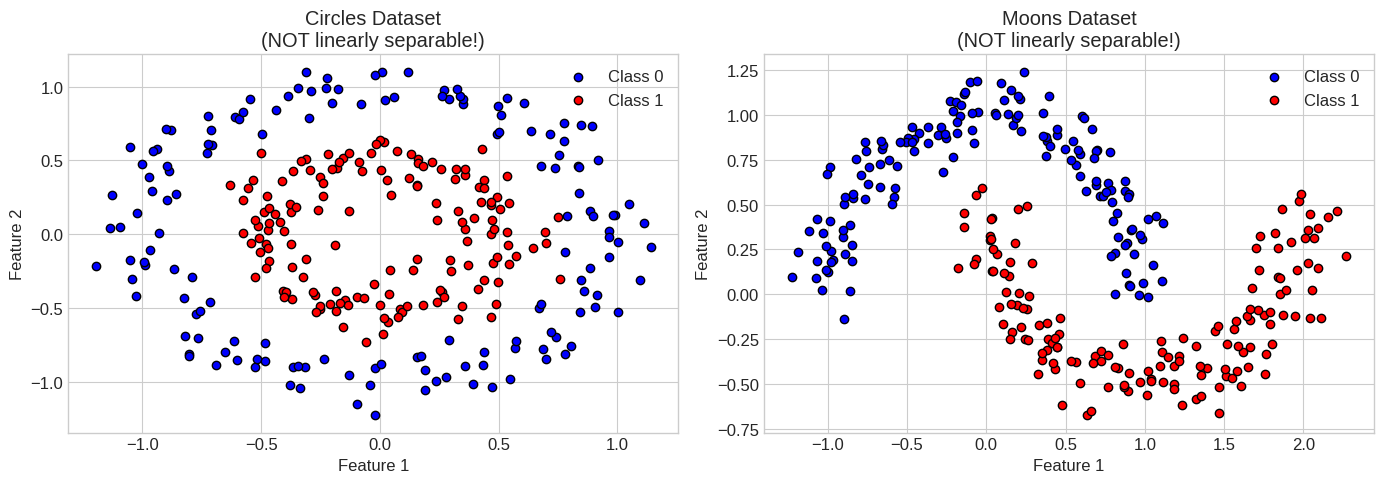

In [ ]:
# Create non-linear data: circles
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=42)

# Moons data
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (X, y, name) in zip(axes, [(X_circles, y_circles, 'Circles'),
                                    (X_moons, y_moons, 'Moons')]):
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', edgecolors='black')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', edgecolors='black')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'{name} Dataset\n(NOT linearly separable!)')
    ax.legend()

plt.tight_layout()
plt.show()

Logistic Regression Accuracy on Circles: 49.67%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128546 (\N{CRYING FACE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


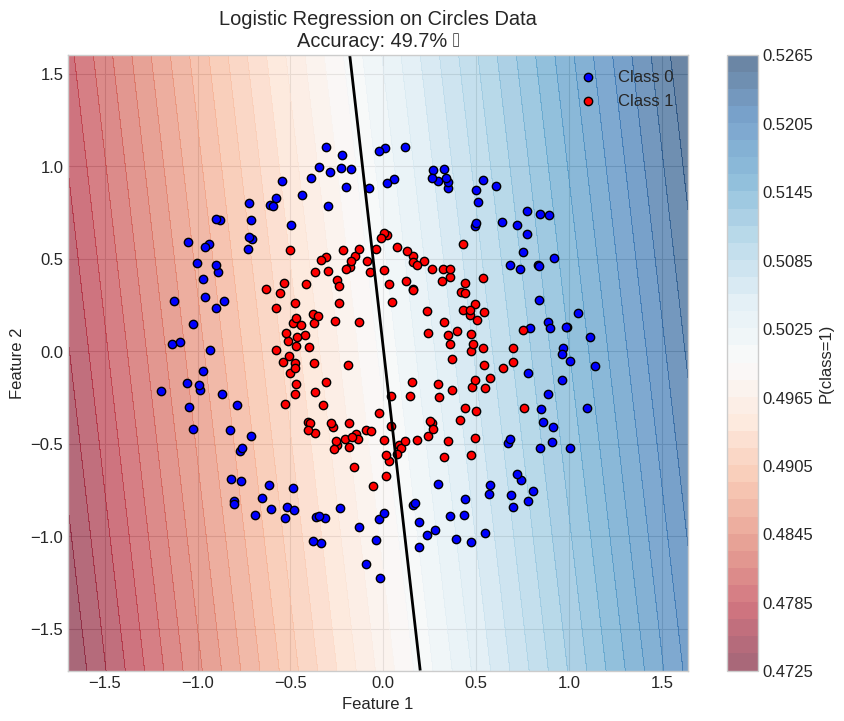

In [ ]:
# Try logistic regression on circles data
X_tensor_circles = torch.FloatTensor(X_circles)
y_tensor_circles = torch.FloatTensor(y_circles).reshape(-1, 1)

model_logistic_circles = LogisticRegression(input_dim=2)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_logistic_circles.parameters(), lr=0.5)

# Train
for epoch in range(300):
    y_pred = model_logistic_circles(X_tensor_circles)
    loss = criterion(y_pred, y_tensor_circles)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate
with torch.no_grad():
    predicted = (model_logistic_circles(X_tensor_circles) > 0.5).float()
    accuracy = (predicted == y_tensor_circles).float().mean()
    print(f"Logistic Regression Accuracy on Circles: {accuracy.item()*100:.2f}%")

plt.figure(figsize=(10, 8))
plot_decision_boundary(model_logistic_circles, X_circles, y_circles,
                       f'Logistic Regression on Circles Data\nAccuracy: {accuracy.item()*100:.1f}% 😢')
plt.show()

## 💡 Key Insight: Limitation of Logistic Regression

Logistic Regression hanya bisa membuat **linear decision boundary** (garis lurus).

Untuk data yang complex/non-linear, kita butuh sesuatu yang lebih powerful...

**Pertanyaan:** Bagaimana kalau kita "stack" multiple logistic regression? 🤔

---
# Part 3: What If We Stack Them? → Neural Network!

## Ide Utama

```
Input → [Linear → Activation] → [Linear → Activation] → ... → Output
         \_____ Layer 1 _____/   \_____ Layer 2 _____/
```

Dengan menambahkan **hidden layers**, kita bisa learn **non-linear patterns**!

## 3.1 Building a Simple Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()

        # Hidden layer: Linear + Activation
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()  # atau sigmoid, tanh, dll

        # Output layer
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.activation2 = nn.Sigmoid()

    def forward(self, x):
        # Layer 1
        out = self.layer1(x)
        out = self.activation1(out)

        # Layer 2 (output)
        out = self.layer2(out)
        out = self.activation2(out)

        return out

# Create model with 8 hidden neurons
model_nn = NeuralNetwork(input_dim=2, hidden_dim=8, output_dim=1)

print("Neural Network Architecture:")
print(model_nn)
print(f"\nTotal parameters: {sum(p.numel() for p in model_nn.parameters())}")

Neural Network Architecture:
NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=8, out_features=1, bias=True)
  (activation2): Sigmoid()
)

Total parameters: 33


In [ ]:
# Training on Circles data
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.1)

losses_nn = []
n_epochs = 500

for epoch in range(n_epochs):
    y_pred = model_nn(X_tensor_circles)
    loss = criterion(y_pred, y_tensor_circles)
    losses_nn.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            predicted = (model_nn(X_tensor_circles) > 0.5).float()
            accuracy = (predicted == y_tensor_circles).float().mean()
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item()*100:.2f}%")

# Final accuracy
with torch.no_grad():
    predicted = (model_nn(X_tensor_circles) > 0.5).float()
    final_accuracy = (predicted == y_tensor_circles).float().mean()
    print(f"\n✅ Final Accuracy: {final_accuracy.item()*100:.2f}%")

Epoch [100/500], Loss: 0.0259, Accuracy: 99.67%
Epoch [200/500], Loss: 0.0227, Accuracy: 99.67%
Epoch [300/500], Loss: 0.0220, Accuracy: 99.67%
Epoch [400/500], Loss: 0.0218, Accuracy: 99.67%
Epoch [500/500], Loss: 0.0217, Accuracy: 99.67%

✅ Final Accuracy: 99.67%


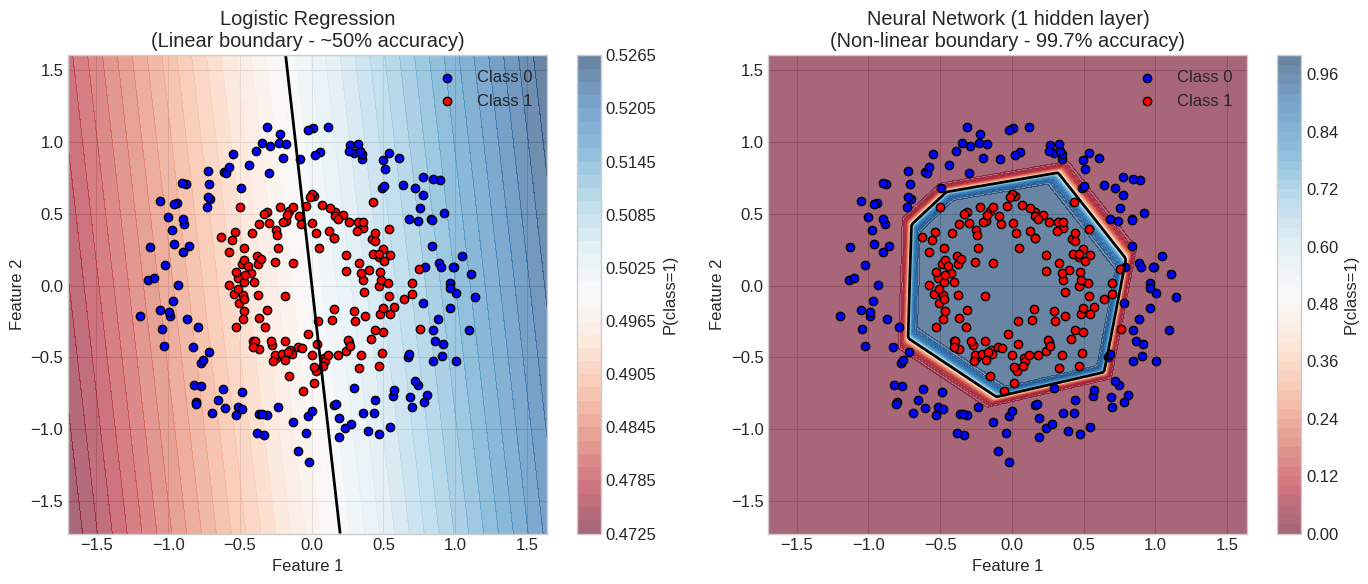

In [ ]:
# Compare decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression
plt.sca(axes[0])
plot_decision_boundary(model_logistic_circles, X_circles, y_circles,
                       'Logistic Regression\n(Linear boundary - ~50% accuracy)')

# Neural Network
plt.sca(axes[1])
plot_decision_boundary(model_nn, X_circles, y_circles,
                       f'Neural Network (1 hidden layer)\n(Non-linear boundary - {final_accuracy.item()*100:.1f}% accuracy)')

plt.tight_layout()
plt.show()

## 3.2 Kenapa Activation Functions Penting?

**Tanpa activation function**, stacking linear layers tidak ada gunanya:

$$\text{Layer 2}(\text{Layer 1}(x)) = W_2(W_1 x + b_1) + b_2 = (W_2 W_1)x + (W_2 b_1 + b_2) = W'x + b'$$

Hasilnya tetap linear! Activation function memberikan **non-linearity** yang kita butuhkan.

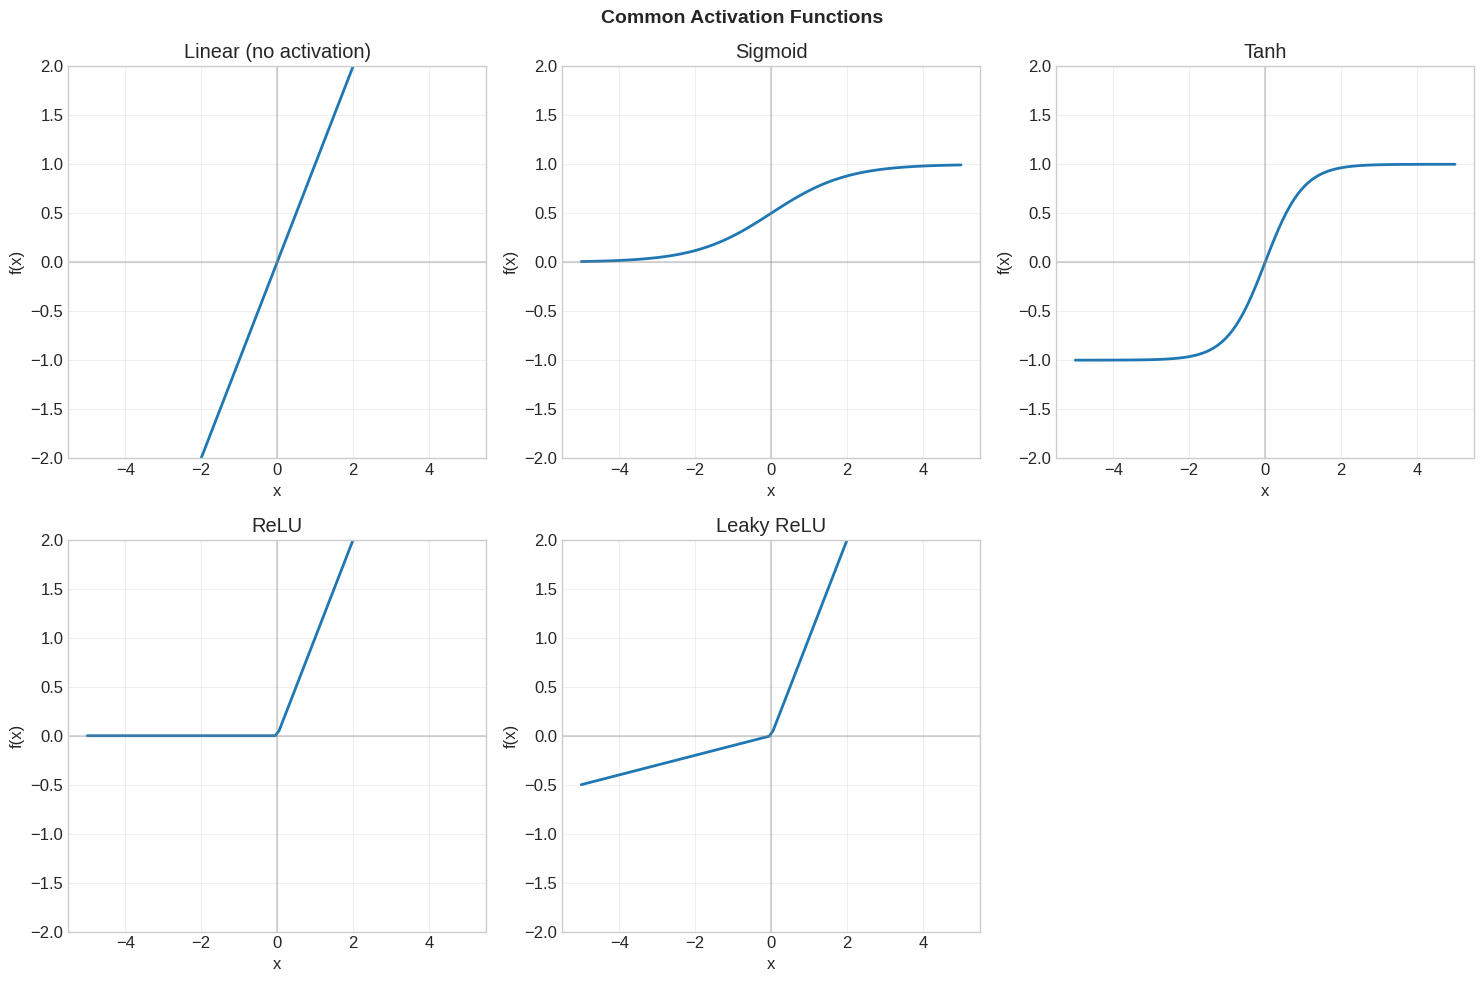

In [ ]:
# Visualisasi berbagai activation functions
x = np.linspace(-5, 5, 100)

activations = {
    'Linear (no activation)': x,
    'Sigmoid': 1 / (1 + np.exp(-x)),
    'Tanh': np.tanh(x),
    'ReLU': np.maximum(0, x),
    'Leaky ReLU': np.where(x > 0, x, 0.1 * x)
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, y) in zip(axes, activations.items()):
    ax.plot(x, y, linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(name)
    ax.set_ylim(-2, 2)
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')  # Hide empty subplot
plt.suptitle('Common Activation Functions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.3 Experiment: Effect of Hidden Layer Size

In [ ]:
hidden_sizes = [2, 4, 8, 16, 32, 64]
results = {}

for h_size in hidden_sizes:
    # Create and train model
    model = NeuralNetwork(input_dim=2, hidden_dim=h_size, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.BCELoss()

    for epoch in range(500):
        y_pred = model(X_tensor_circles)
        loss = criterion(y_pred, y_tensor_circles)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    with torch.no_grad():
        predicted = (model(X_tensor_circles) > 0.5).float()
        accuracy = (predicted == y_tensor_circles).float().mean()

    results[h_size] = {'model': model, 'accuracy': accuracy.item()}
    print(f"Hidden size: {h_size:2d} → Accuracy: {accuracy.item()*100:.2f}%")

Hidden size:  2 → Accuracy: 64.00%
Hidden size:  4 → Accuracy: 99.67%
Hidden size:  8 → Accuracy: 100.00%
Hidden size: 16 → Accuracy: 100.00%
Hidden size: 32 → Accuracy: 100.00%
Hidden size: 64 → Accuracy: 100.00%


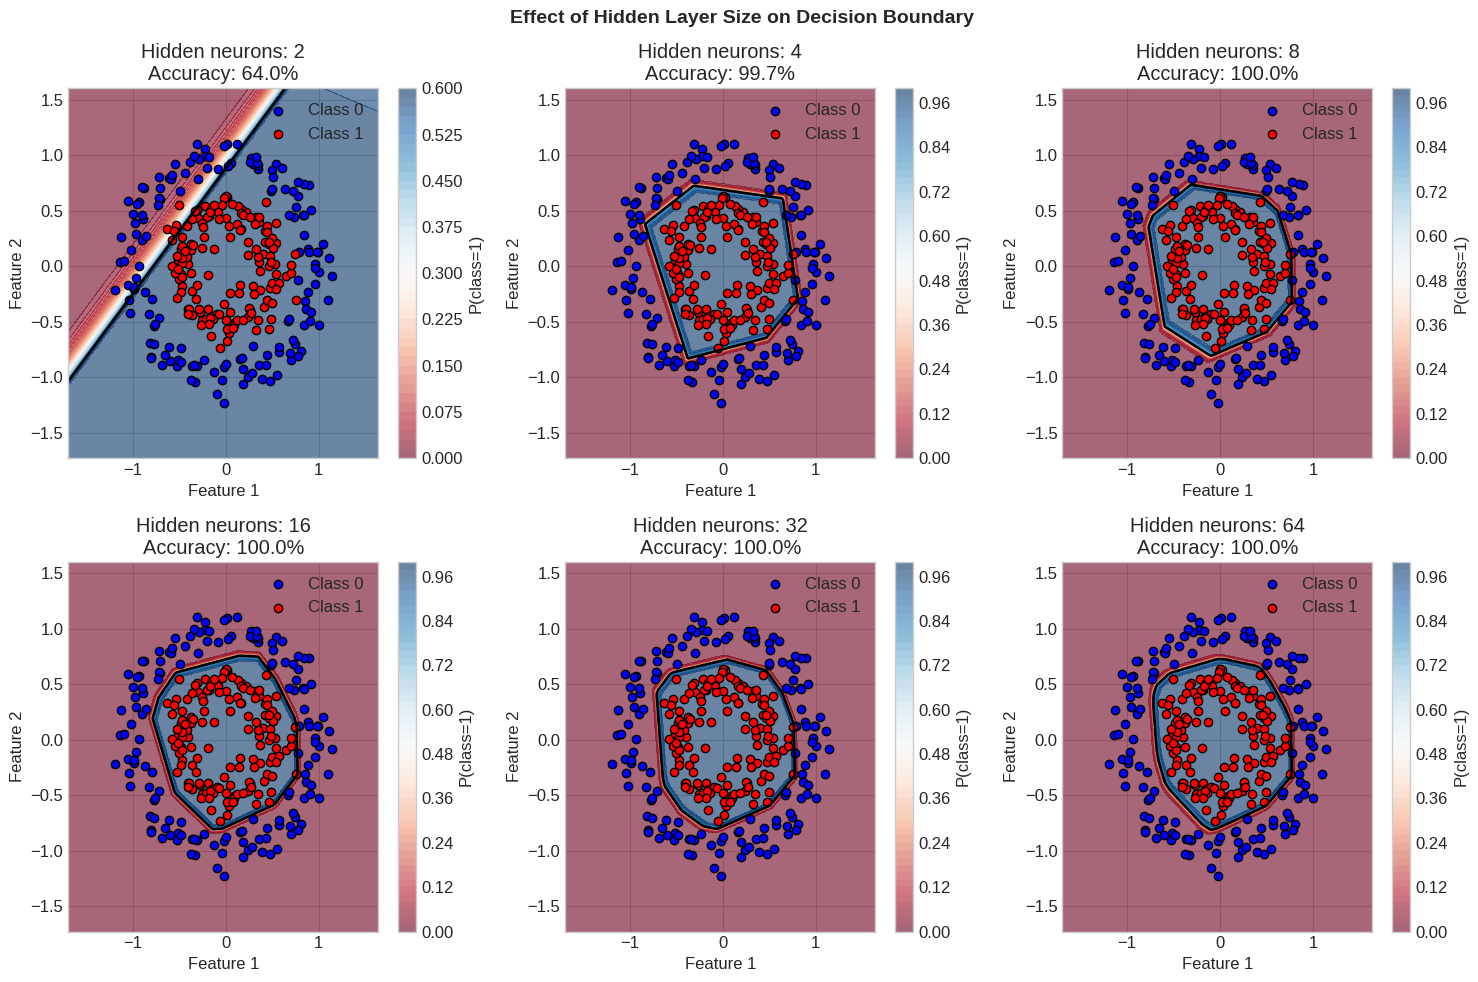

In [ ]:
# Visualize decision boundaries for different hidden sizes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, h_size in zip(axes, hidden_sizes):
    plt.sca(ax)
    model = results[h_size]['model']
    acc = results[h_size]['accuracy']
    plot_decision_boundary(model, X_circles, y_circles,
                          f'Hidden neurons: {h_size}\nAccuracy: {acc*100:.1f}%')

plt.suptitle('Effect of Hidden Layer Size on Decision Boundary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Experiment: Effect of Hidden Layer Size on Moons Data
hidden_sizes = [2, 4, 8, 16, 32, 64]
results_moons = {}

for h_size in hidden_sizes:
    # Create and train model
    model = NeuralNetwork(input_dim=2, hidden_dim=h_size, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.BCELoss()

    for epoch in range(500):
        y_pred = model(X_tensor_moons)
        loss = criterion(y_pred, y_tensor_moons)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    with torch.no_grad():
        predicted = (model(X_tensor_moons) > 0.5).float()
        accuracy = (predicted == y_tensor_moons).float().mean()

    results_moons[h_size] = {'model': model, 'accuracy': accuracy.item()}
    print(f"Hidden size: {h_size:2d} → Accuracy: {accuracy.item()*100:.2f}%")

Hidden size:  2 → Accuracy: 50.00%
Hidden size:  4 → Accuracy: 89.33%
Hidden size:  8 → Accuracy: 100.00%
Hidden size: 16 → Accuracy: 100.00%
Hidden size: 32 → Accuracy: 100.00%
Hidden size: 64 → Accuracy: 100.00%


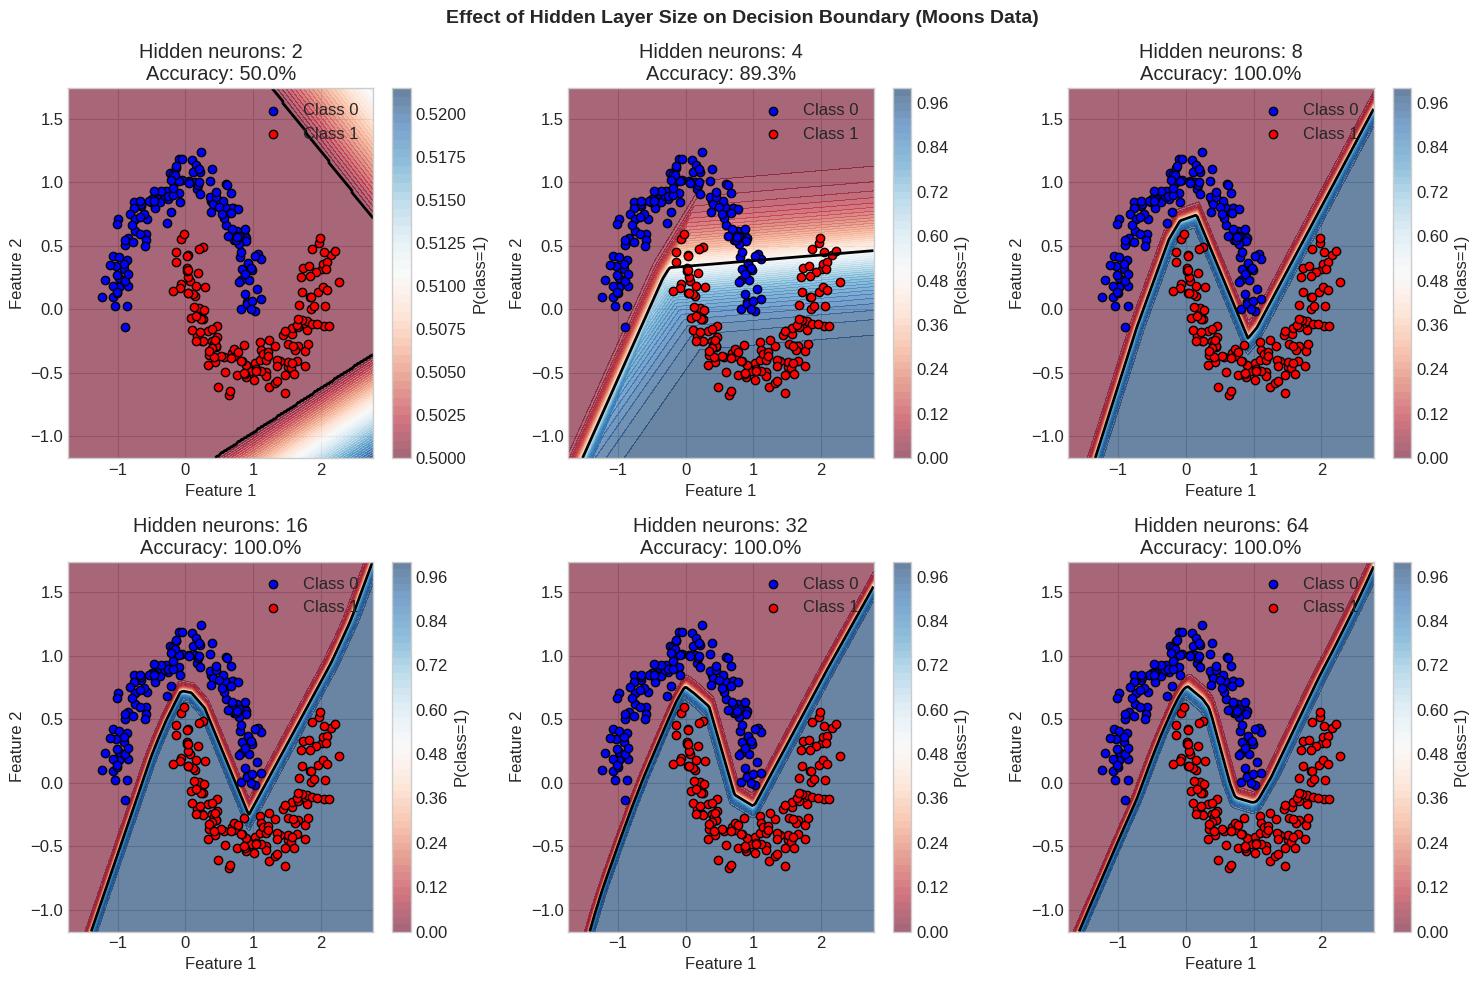

In [ ]:
# Visualize decision boundaries for different hidden sizes on Moons
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, h_size in zip(axes, hidden_sizes):
    plt.sca(ax)
    model = results_moons[h_size]['model']
    acc = results_moons[h_size]['accuracy']
    plot_decision_boundary(model, X_moons, y_moons,
                          f'Hidden neurons: {h_size}\nAccuracy: {acc*100:.1f}%')

plt.suptitle('Effect of Hidden Layer Size on Decision Boundary (Moons Data)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.4 Going Deeper: Multiple Hidden Layers

In [ ]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DeepNeuralNetwork, self).__init__()

        layers = []
        prev_dim = input_dim

        # Build hidden layers
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Create a deeper network
model_deep = DeepNeuralNetwork(
    input_dim=2,
    hidden_dims=[16, 8, 4],  # 3 hidden layers
    output_dim=1
)

print("Deep Neural Network:")
print(model_deep)
print(f"\nTotal parameters: {sum(p.numel() for p in model_deep.parameters())}")

Deep Neural Network:
DeepNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Total parameters: 225


Deep NN Accuracy on Moons: 100.00%


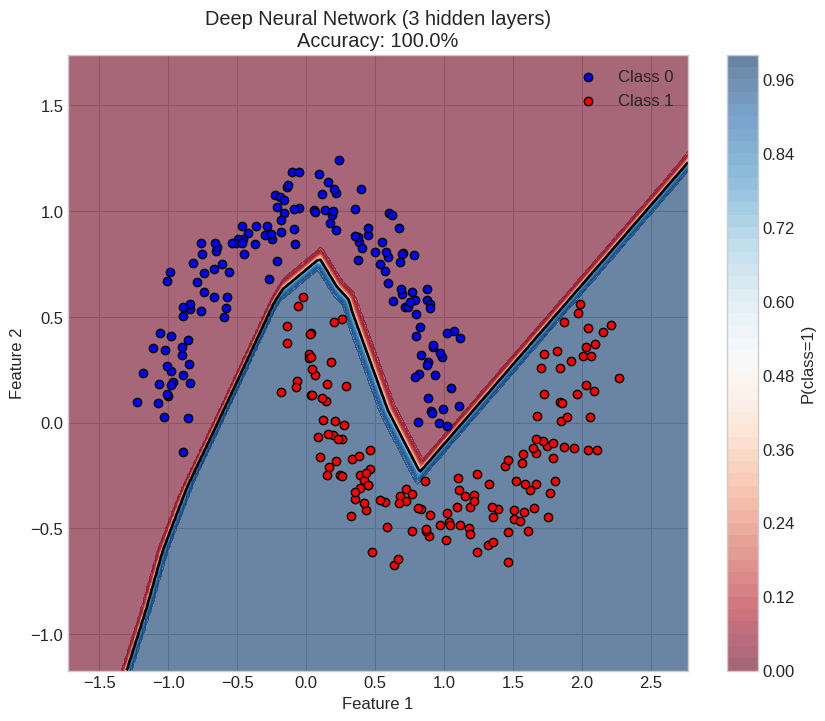

In [ ]:
# Train on Moons data (lebih challenging)
X_tensor_moons = torch.FloatTensor(X_moons)
y_tensor_moons = torch.FloatTensor(y_moons).reshape(-1, 1)

optimizer = optim.Adam(model_deep.parameters(), lr=0.05)
criterion = nn.BCELoss()

for epoch in range(1000):
    y_pred = model_deep(X_tensor_moons)
    loss = criterion(y_pred, y_tensor_moons)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate
with torch.no_grad():
    predicted = (model_deep(X_tensor_moons) > 0.5).float()
    accuracy = (predicted == y_tensor_moons).float().mean()
    print(f"Deep NN Accuracy on Moons: {accuracy.item()*100:.2f}%")

plt.figure(figsize=(10, 8))
plot_decision_boundary(model_deep, X_moons, y_moons,
                       f'Deep Neural Network (3 hidden layers)\nAccuracy: {accuracy.item()*100:.1f}%')
plt.show()

---
# Summary: The Journey

## Dari Linear ke Neural Network

| Model | Formula | Capability |
|-------|---------|------------|
| **Linear Regression** | $y = Wx + b$ | Predict continuous values, linear only |
| **Logistic Regression** | $y = \sigma(Wx + b)$ | Binary classification, linear boundary |
| **Neural Network** | $y = \sigma(W_2 \cdot \text{ReLU}(W_1 x + b_1) + b_2)$ | Non-linear patterns! |

## Key Takeaways

1. **Linear Regression** adalah building block paling dasar

2. **Logistic Regression** = Linear + Sigmoid → bisa klasifikasi, tapi cuma linear boundary

3. **Neural Network** = Stack multiple linear+activation layers → bisa learn complex patterns

4. **Activation functions** memberikan non-linearity yang crucial

5. Lebih banyak hidden neurons/layers = lebih powerful, tapi juga risiko **overfitting**

/tmp/ipython-input-1878651672.py:20: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1878651672.py:20: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()


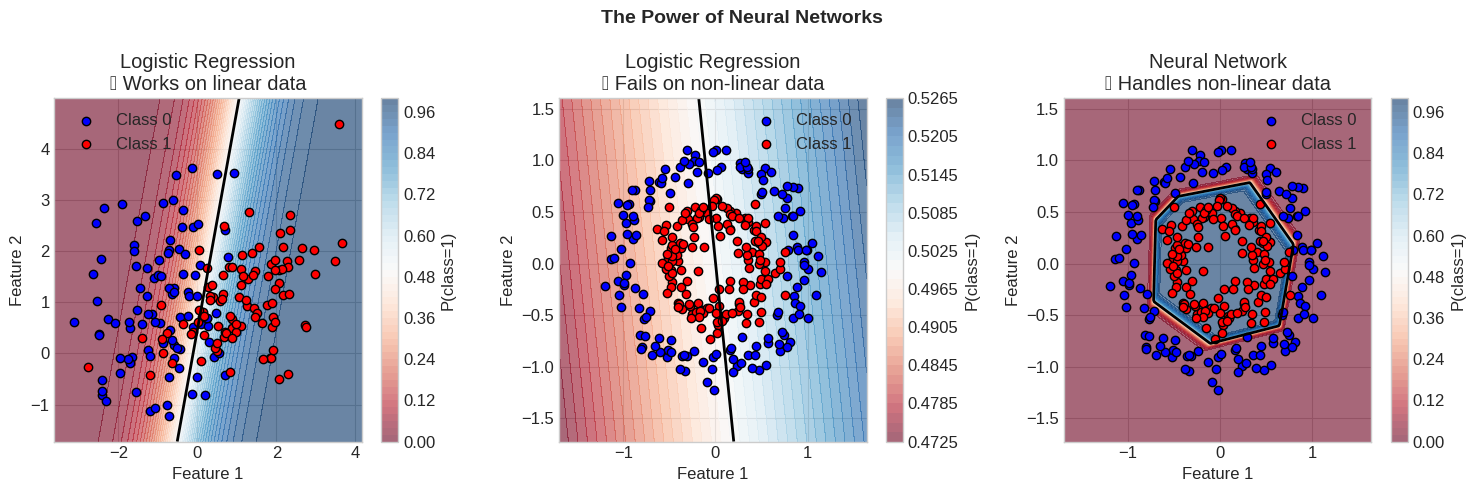

In [ ]:
# Final comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Logistic on linear data
plt.sca(axes[0])
plot_decision_boundary(model_logistic, X_class, y_class,
                       'Logistic Regression\n✅ Works on linear data')

# 2. Logistic on circles
plt.sca(axes[1])
plot_decision_boundary(model_logistic_circles, X_circles, y_circles,
                       'Logistic Regression\n❌ Fails on non-linear data')

# 3. NN on circles
plt.sca(axes[2])
plot_decision_boundary(model_nn, X_circles, y_circles,
                       'Neural Network\n✅ Handles non-linear data')

plt.suptitle('The Power of Neural Networks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# 🎯 Exercises

## Bagian A: Arsitektur & Komponen

1. **Experiment with activations**: Ganti ReLU dengan Sigmoid atau Tanh di hidden layer. Apa yang berubah pada decision boundary dan training speed?

2. **Add more layers**: Buat network dengan 5 hidden layers (misalnya: 32→16→8→4→2). Apakah selalu lebih baik? Bandingkan dengan network 1 hidden layer dengan jumlah parameter yang sama.

3. **No activation experiment**: Hapus semua activation function di hidden layers (hanya keep sigmoid di output). Train pada circles data. Apa yang terjadi dan mengapa?

## Bagian B: Training Dynamics

4. **Try different optimizers**: Bandingkan Adam, SGD, dan SGD dengan momentum (momentum=0.9) pada moons data. Plot loss curve ketiganya dalam satu grafik.

5. **Learning rate experiment**: Coba learning rate 0.001, 0.01, 0.1, 1.0 dengan optimizer yang sama. Apa yang terjadi pada masing-masing? Visualisasikan loss curve-nya.

6. **Batch training**: Ubah training loop untuk menggunakan mini-batch (batch_size=32) instead of full batch. Gunakan `torch.utils.data.DataLoader`. Apakah ada perbedaan pada convergence speed?

## Bagian C: Generalization & Overfitting

7. **Overfitting challenge**: Generate circles data dengan n_samples=50. Train network besar (hidden_dim=128). Plot train accuracy vs waktu. Apa yang terjadi?

8. **Train-test split**: Split data menjadi 80% train dan 20% test. Train model dan bandingkan train accuracy vs test accuracy. Kapan gap-nya mulai besar?

9. **Regularization**: Tambahkan L2 regularization dengan menambahkan `weight_decay=0.01` di optimizer. Apakah membantu mengurangi overfitting dari exercise 7?

## Bagian D: Challenge

10. **Custom dataset**: Buat dataset sendiri yang lebih complex menggunakan kombinasi `make_moons` dan `make_circles` (hint: gabungkan dan shift posisinya). Design network yang bisa achieve >95% accuracy. Berapa minimum hidden neurons yang dibutuhkan?

In [ ]:
# Space for your experiments!

